# ECG Arrhythmia Detection Using Discrete Wavelet Transform

In this notebook stands the foundation of the whole ECG analysis and arrhythmia detection, using the discrete wavelet transform (DWT) and the MIT-BIH Arrhythmia Database in order to detect anomalies based on data. 

## 0. Setup

In this section, we import all libraries needed before proceeding. 

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
import wfdb
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                            accuracy_score, precision_recall_fscore_support, f1_score)
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GroupShuffleSplit


## 1. Data Loading and Preprocessing

- `load_mit_bih_db`: this function loads the dataset and saves the ECG signal, sampling frequency, and any available annotations. 
- `preprocess`: this function works the ECG original signal based on the samplig frequency for baseline wander removal and normalization of the signal. For the Butterworth filter, it was chosen to be represented in sos format (second-order sections) to increase stability asa this is a high-order filter. 

In [2]:
def load_mit_bih_db(record_name = '100', duration = 10): 
    """
    ecg_signal: ndarray 
        ECG signal MLII lead.
    fs: int 
        sampling frequency. 
    ann_dict : dict 
        annotation data from each ecg. 
    """
    # mit-bih is sampled at 360 Hz, we're looking at 10 * 360 = 3600 samples of data
    record = wfdb.rdrecord(record_name, pn_dir='mitdb', sampto=duration*360)
    annotation = wfdb.rdann(record_name, 'atr', pn_dir='mitdb', sampto=duration*360)
    
    # signal MLII extraction that exists on the first channel. 
    ecg_signal = record.p_signal[:, 0]
    fs = record.fs
    
    # annotations from each ecg 
    ann_dict = {
        'sample': annotation.sample,
        'symbol': annotation.symbol,  # N=normal
    }
    
    return ecg_signal, fs, ann_dict

def preprocess(ecg_signal, fs): 
    """ 
    processed_signal: ndarray 
        preprocessed ECG signal (baseline wander removal and normalization)
    """
    
    # we remove the baseline wander with the High-Pass Filter, using a 0.5 Hz cutoff
    sos = signal.butter(4, 0.5, btype = 'high' , fs=fs, output='sos')
    filtered = signal.sosfilt(sos, ecg_signal)
    # normalization 
    processed_signal = (filtered - np.mean(filtered))/np.std(filtered) 
    
    return processed_signal


## 2. DWT Decomposition and Analysis 

- `dwt`: using the wavelet Daubechies 4 as it's most commonly used in practice and experimentation for these type of projects. The use of a level 5 decomposition comes from knowing that the frequency is 360 Hz. Each level splits the frequency band in a way that results easier to see and recognize the necessary frequency for the QRS complex, which is our main focus. This complex has most energy around 5-40 Hz, which makes coefficients cD3 and cD4 the best for R-peak detection. 
- `reconstruct`: this functions uses the coefficientes obtained through the wavelet decomposition function in order to reconstruct it. 
- `calc_entropy`: calculation of Shannon Entropy based on the wavelet's coefficients. This functino is used on `dwt_feats`.
- `dwt_feats`: returns the dictionary `features` that contains information regarding the distinct coefficients obtained during function `dwt`.

In [3]:
def dwt(ecg_signal, wavelet = 'db4', level = 5): 
    """ 
    coeffs: list 
        wavelet coefficients [cA5, cD5, cD4, cD3, cD2, cD1] <- total 6 elements 
    """
    # wavelet decomposition function from pywt
    coeffs = pywt.wavedec(ecg_signal, wavelet, level = level)
    return coeffs 

def reconstruct(coeffs, wavelet='db4'): 
    """ 
    recons: ndarray 
        reconstructed signal based on coefficients
    """
    # wavelet recomposition function from pywt 
    recons = pywt.waverec(coeffs, wavelet) 

def calc_entropy(coeffs): 
    # calculation of Shannon entropy of wavelet coefficients

    energy = coeffs**2
    total_energy = np.sum(energy) 

    if (total_energy == 0):
        return 0
    prob_dist = energy/total_energy

    prob_dist = prob_dist[prob_dist > 0]
    entropy = -np.sum(prob_dist * np.log2(prob_dist))
    return entropy 

def dwt_feats(coeffs): 
    """ 
    features: dict 
        includes the following features of the DWT: 
        - cA Energy
        - cA Mean 
        - cA Standard Dev. 
        - cA Entropy
        - For every cD, includes energy, mean, standard dev., max coefficient value, and entropy in their detail level
    """
    features = {}

    # saving the approx. coefficients (low freq)
    features['cA_energy'] = np.sum(coeffs[0]**2)
    features['cA_mean'] = np.mean(np.abs(coeffs[0]))
    features['cA_std'] = np.std(coeffs[0])
    features['cA_entropy'] = calc_entropy(coeffs[0])

    # saving the detail coefficients (high freq) 
    for i, d in enumerate(coeffs[1:],1): 
        features[f'cD{len(coeffs)-i}_energy'] = np.sum(d**2)
        features[f'cD{len(coeffs)-i}_mean'] = np.mean(np.abs(d))
        features[f'cD{len(coeffs)-i}_std'] = np.std(d)
        features[f'cD{len(coeffs)-i}_max'] = np.max(np.abs(d))
        features[f'cD{len(coeffs)-i}_entropy'] = calc_entropy(d)
    
    # final total energy 
    features['total_energy'] = sum(np.sum(c**2) for c in coeffs)
    return features 

def extract_features_from_beats(beats, wavelet='db4', level=4):
    """
    features_dict : dict
        Each key is a feature name, each value is a numpy array of feature values
    """
    all_features = []
    
    for beat in beats:
        feat = dwt_feats(beat, wavelet=wavelet, level=level)
        all_features.append(feat)
    
    # Organize into dict of arrays (one array per feature)
    feature_names = all_features[0].keys()
    features_dict = {}
    
    for name in feature_names:
        features_dict[name] = np.array([f[name] for f in all_features])
    
    return features_dict

## 3. Beat Segmentation and Feature Comparison

- `segments`: this function divides the electrocardiogram in windows around the R peak, helping to catalogize each heartbeat as its own and identify it's behavior directly, instead of analyzing the ECG as a whole. 
- `extract_beat_fts`: similar to the function `dwt_feats`, this function extracts the coefficients and features of a specific beat. 
- `avg_fts`: this function analyzes all beat segments from the original ECG signal and returns the average features per each category of beat, using the average as a more representative value of comparison. 

In [4]:
def segments(ecg_signal, anns, fs, window_size = 0.3): 
    """ 
    beats: dict
        beat type as key and list of beat segments
    """

    half_window = int(window_size *fs/2) 
    beats = {}

    for sample, symbol in zip(anns['sample'], anns['symbol']): 
        start = max(0, sample - half_window) 
        end = min(len(ecg_signal), sample + half_window) 

        beat_seg = ecg_signal[start:end] 

        if(len(beat_seg) == 2*half_window): 
            if(symbol not in beats): 
                beats[symbol] = []
            beats[symbol].append(beat_seg) 
        
    return beats

def extract_beat_fts(beat_seg, wavelet = 'db4', level = 5): 
    coeffs = dwt(beat_seg, wavelet = wavelet, level = level) 
    feats = dwt_feats(coeffs) 
    return feats 

def avg_fts(beats, wavelet = 'db4', level = 5): 
    all_fts = []
    
    for beat in beats: 
        feat = extract_beat_fts(beat, wavelet = wavelet, level = level) 
        all_fts.append(feat)
    
    avg_feats = {}
    fts_names = all_fts[0].keys() 

    for name in fts_names: 
        values = [f[name] for f in all_fts]
        avg_feats[name] = np.mean(values) 

    return avg_feats 

## 4. Visualization 

- `plot_signal_ann`: function that plots the original ECG signal on a time vs normalized amplitude, and includes the corresponding annotations. 
- `plot_dwt_decomposition`: using the distinct coefficients, a graph of the distinct DWT levels are plotted. 
- `plot_feature_comparison`: plots a comparison between features, in case abnormal beats are detected in segments of the ECG. 

In [5]:
def plot_signal_ann(ecg_signal, fs, annotations, duration=5):
    """ 
    plots original signal with its respective annotations
    """
    # we create a time array for plotting. 
    time = np.arange(len(ecg_signal)) / fs
    plt.figure(figsize=(15, 4))
    plt.plot(time, ecg_signal, 'b-', linewidth=0.5, label='ECG Signal')
    
    # Plot annotations
    for sample, symbol in zip(annotations['sample'], annotations['symbol']):
        if sample < len(ecg_signal):
            plt.plot(time[sample], ecg_signal[sample], 'ro', markersize=6)
            plt.text(time[sample], ecg_signal[sample], f' {symbol}', fontsize=10)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (normalized)')
    plt.title('ECG Signal with Annotations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, duration)
    plt.tight_layout()
    plt.show()


def plot_dwt_decomposition(coeffs, fs, wavelet='db4'):
    """
    plots all levels of dwt decomposition
    """

    n_levels = len(coeffs) - 1
    fig, axes = plt.subplots(n_levels + 1, 1, figsize=(15, 2*n_levels))
    
    # plot approximation coefficients
    axes[0].plot(coeffs[0], 'g-', linewidth=0.8)
    axes[0].set_title(f'Approximation Coefficients (cA{n_levels})')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Plot detail coefficients
    for i, detail in enumerate(coeffs[1:], 1):
        axes[i].plot(detail, 'b-', linewidth=0.8)
        level = n_levels - i + 1
        
        # Calculate frequency range for this level
        freq_max = fs / (2 ** (i))
        freq_min = fs / (2 ** (i + 1))
        
        axes[i].set_title(f'Detail Coefficients (cD{level}) - Freq: {freq_min:.1f}-{freq_max:.1f} Hz')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Sample Index')
    plt.tight_layout()
    plt.show()

def plot_feature_comparison(normal_features, abnormal_features):
    feature_names = list(normal_features.keys())
    normal_values = list(normal_features.values())
    abnormal_values = list(abnormal_features.values())
    
    x = np.arange(len(feature_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 6))
    bars1 = ax.bar(x - width/2, normal_values, width, label='Normal', alpha=0.8)
    bars2 = ax.bar(x + width/2, abnormal_values, width, label='Abnormal', alpha=0.8)
    
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Value', fontsize=12)
    ax.set_title('DWT Feature Comparison: Normal vs Abnormal Beats')
    ax.set_xticks(x)
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


## 5. Example Usage

This section divides in two parts: an analysis and recognition of the R-peaks in a 10 second segment of an ECG, and a comparison between location of R-peaks in the average normal heartbeat of the patient and any abnormalities that they may have. 

### Key variables
- `drtn`: duration of the record to analyze (s) 
- `ecg`: electrocardiogram for the analysis 
- `fs`: sampling frequency (Hz) 
- `ann`: annotations on the chosen record 
- `ecg_processed`: preprocessed ECG signal using the sampling frequency `fs`
- `lvl`: decomposition level 
- `features`: features from the extracted electrocardiogram

signal length: 9000 samples
sampling frequency: 360 Hz
number of annotations: 39
annotation types: {'N', 'V', '+'}


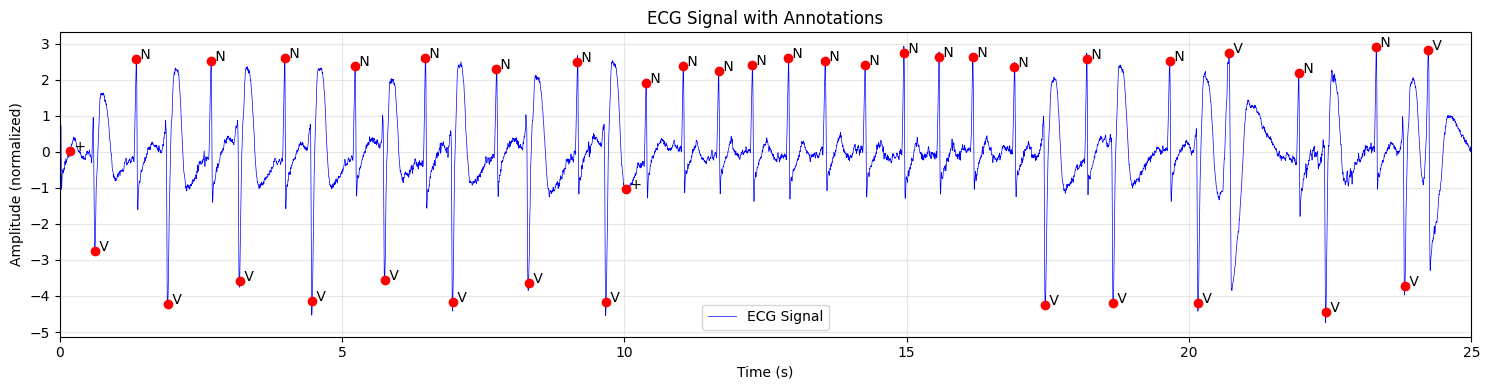


performing DWT decomposition
number of decomposition levels: 5
  cA5: 288 coefficients
  cD5: 288 coefficients
  cD4: 569 coefficients
  cD3: 1131 coefficients
  cD2: 2255 coefficients
  cD1: 4503 coefficients


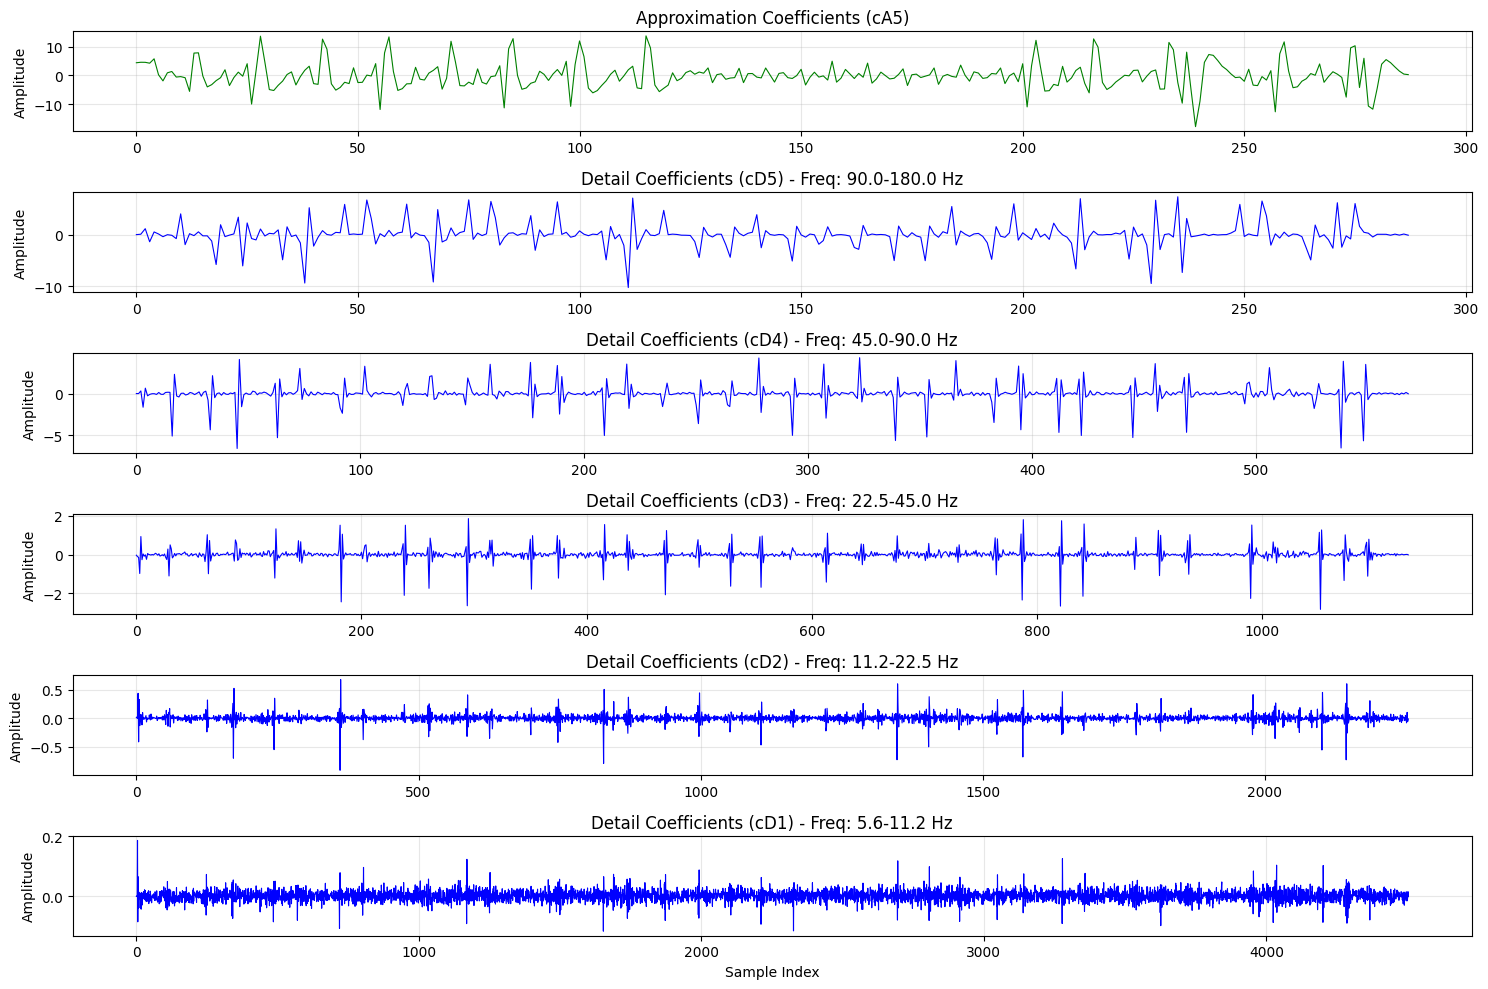


extracted DWT features:
  cA_energy: 6288.3850
  cA_mean: 3.3084
  cA_std: 4.6720
  cA_entropy: 6.5660
  cD5_energy: 1803.7886
  cD5_mean: 1.4121
  cD5_std: 2.5026
  cD5_max: 10.2200
  cD5_entropy: 5.8929
  cD4_energy: 842.7074
  cD4_mean: 0.5454
  cD4_std: 1.2164
  cD4_max: 6.5540
  cD4_entropy: 6.0093
  cD3_energy: 155.6818
  cD3_mean: 0.1622
  cD3_std: 0.3710
  cD3_max: 2.8281
  cD3_entropy: 6.5326
  cD2_energy: 18.3639
  cD2_mean: 0.0516
  cD2_std: 0.0902
  cD2_max: 0.9186
  cD2_entropy: 8.0309
  cD1_energy: 1.6667
  cD1_mean: 0.0140
  cD1_std: 0.0192
  cD1_max: 0.1861
  cD1_entropy: 10.4526
  total_energy: 9110.5933


In [6]:
# example: loading and analyzing a record
# duration 
drtn = 25
ecg, fs, ann = load_mit_bih_db('200', duration=drtn)

print(f"signal length: {len(ecg)} samples")
print(f"sampling frequency: {fs} Hz")
print(f"number of annotations: {len(ann['sample'])}")
print(f"annotation types: {set(ann['symbol'])}")

# preprocess
ecg_processed = preprocess(ecg, fs)
# visualize
plot_signal_ann(ecg_processed, fs, ann, duration=drtn)

# decomposition level 
lvl = 5

# perform the dwt
print("\nperforming DWT decomposition")
coeffs = dwt(ecg_processed, wavelet='db4', level=lvl)

print(f"number of decomposition levels: {len(coeffs)-1}")
for i, c in enumerate(coeffs):
    if(i == 0):
        print(f"  cA{len(coeffs)-1}: {len(c)} coefficients")
    else:
        print(f"  cD{len(coeffs)-i}: {len(c)} coefficients")

# visualize decomposition
plot_dwt_decomposition(coeffs, fs, wavelet='db4')

# extract features from a segment
features = dwt_feats(coeffs)
print("\nextracted DWT features:")
for name, value in features.items():
    print(f"  {name}: {value:.4f}")


beat types found: ['+', 'V', 'N']
+: 2
V: 15
N: 22

abnormal features were identified (type 'V'). extracting features...


C:\Users\Laurie Hernández\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


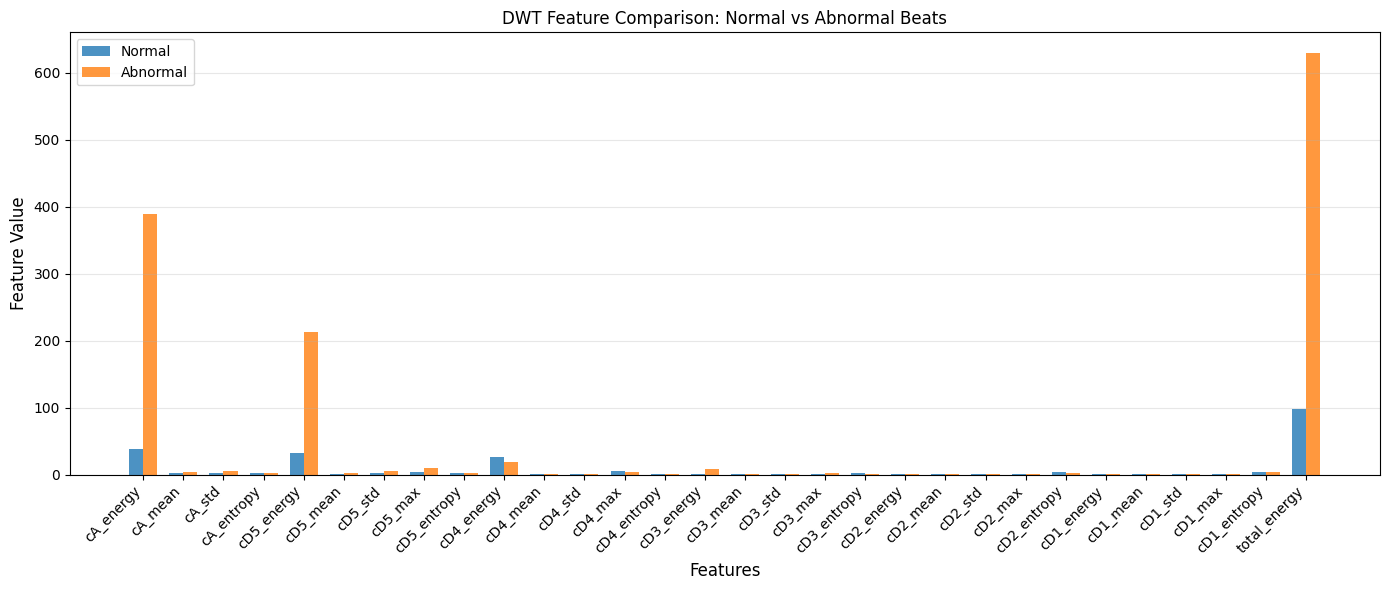


key feature differences:
feature              normal          abnormal        ratio     
cD3_energy           0.6590          8.1962          12.44     x
cD4_energy           25.8864         18.3862         0.71      x
cD3_max              0.5464          2.3080          4.22      x
cD4_max              4.6275          3.6630          0.79      x
cD3_entropy          2.1784          1.3574          0.62      x
cD4_entropy          0.8029          1.1704          1.46      x


In [7]:
beats = segments(ecg_processed, ann, fs, window_size = 0.3) 
print(f"beat types found: {list(beats.keys())}")

for beat_type, beat_list in beats.items(): 
    print(f"{beat_type}: {len(beat_list)}")

if('N' in beats): 
    n_feats = avg_fts(beats['N'][:10], wavelet='db4', level = lvl)

abnorm = None
for t in ['V', 'A', 'L', 'R', '/']: 
    if(t in beats and len(beats[t]) > 0): 
        abnorm = t 
        break 

if(abnorm): 
    print(f"\nabnormal features were identified (type '{abnorm}'). extracting features...") 
    abn_feats = avg_fts(beats[abnorm][:10], wavelet = 'db4', level = lvl)

    plot_feature_comparison(n_feats, abn_feats) 

    print("\nkey feature differences:")
    print(f"{'feature':<20} {'normal':<15} {'abnormal':<15} {'ratio':<10}")
    for key in ['cD3_energy', 'cD4_energy', 'cD3_max', 'cD4_max', 'cD3_entropy', 'cD4_entropy']:
        if key in n_feats and key in abn_feats:
            ratio = abn_feats[key] / n_feats[key]
            print(f"{key:<20} {n_feats[key]:<15.4f} {abn_feats[key]:<15.4f} {ratio:<10.2f}x")

else:
    print("\nno abnormal beats found in this segment.")


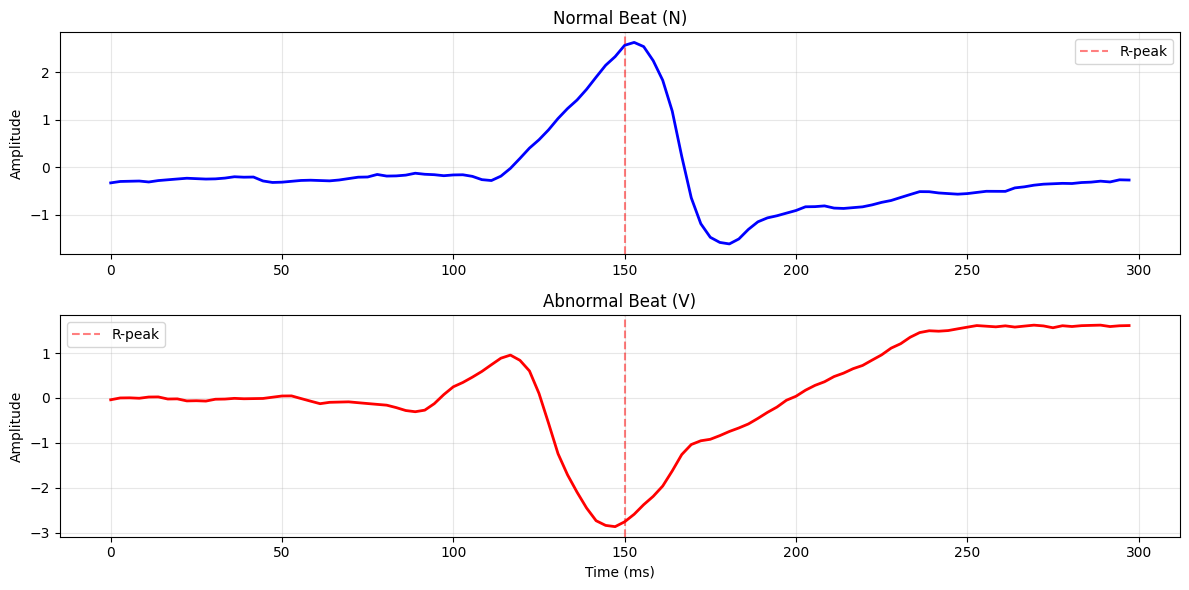

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
if 'N' in beats:
    
    # Plot normal beat
    time_beat = np.arange(len(beats['N'][0])) / fs * 1000  # in milliseconds
    axes[0].plot(time_beat, beats['N'][0], 'b-', linewidth=2)
    axes[0].set_title('Normal Beat (N)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=len(beats['N'][0])/2 * 1000/fs, color='r', linestyle='--', alpha=0.5, label='R-peak')
    axes[0].legend()
    
    # Plot abnormal beat if available
if abnorm:
    axes[1].plot(time_beat, beats[abnorm][0], 'r-', linewidth=2)
    axes[1].set_title(f'Abnormal Beat ({abnorm})')
    axes[1].set_ylabel('Amplitude')
    axes[1].set_xlabel('Time (ms)')
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(x=len(beats[abnorm][0])/2 * 1000/fs, color='r', linestyle='--', alpha=0.5, label='R-peak')
    axes[1].legend()
    
plt.tight_layout()
plt.show()

A significant difference can be seen on the graph above, where the normal beat 'N' has a softer and symmetric distribution, whereas the abnormal beat 'V' is assymetric and has local minimum where the R-peak is supposed to lie, as well as the R peak is located approximately 30 to 40 ms to the left. 

# 6. Statistical Validation of DWT Features

In this section, we'll discuss the statistical significance of DWT features for comparison between normal heartbeats and ventriular arrhythmic heartbeats. Gathering a sample of 50 normal beats 'N' and 50 ventricular arrhythmic beats 'V' from all of the distinct ECGs, this project will further analyze statistical differences and variations between these specific type of beats and validate the significance of the DWT features in order to consider them valid for differentiation.  

The first section will focus on selecting 50 normal random beats and 50 ventricular arrhythmic random beats from all MIT-BIH database, in order to broaden the data and avoid any bias. 

In [52]:
def collect_beats_from_multiple_records(record_list, target_annotation, n_beats=50, duration=60, window_size=0.3):
    """
    collected_beats : list
        List of randomly sampled beat segments
    beat_sources : list
        List of record names for each beat (for tracking diversity)
    """
    all_beats = []
    beat_sources = []
    print(f"Collecting '{target_annotation}' beats from all records...")
    
    for record_name in record_list:
        # Load record
        print(f"  Processing record {record_name}...", end=" ")
        ecg, fs, ann = load_mit_bih_db(record_name, duration=duration)
        ecg_processed = preprocess(ecg, fs)
        
        # Segment beats
        beats = segments(ecg_processed, ann, fs, window_size=window_size)
            
        # Add beats of target type
        if target_annotation in beats:
            count = len(beats[target_annotation])
            all_beats.extend(beats[target_annotation])
            beat_sources.extend([record_name]*count)
            print(f"found {count} beats")
        else:
            print("no beats found")
                
    print(f"\ntotal collected: {len(all_beats)} '{target_annotation}' beats")

    indices = list(range(len(all_beats)))
    random.shuffle(indices)
    selected_indices = indices[:n_beats]
    
    sampled_beats = [all_beats[i] for i in selected_indices]
    sampled_sources = [beat_sources[i] for i in selected_indices]


    return sampled_beats, sampled_sources

random.seed(42)
np.random.seed(42)

# List of all MIT-BIH records
all_records = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', 
               '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
               '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
               '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
               '222', '223', '228', '230', '231', '232', '233', '234']

# collect normal and ventricular beats for 50 samples each. 

n_beats = 50
normal_beats, normal_sources_samp = collect_beats_from_multiple_records(all_records, target_annotation='N', n_beats= n_beats, duration=60)
ventricular_beats, ventricular_sources_samp = collect_beats_from_multiple_records(all_records, target_annotation='V', n_beats= n_beats, duration=60)


  Processing record 100... found 73 beats
  Processing record 101... found 71 beats
  Processing record 102... no beats found
  Processing record 103... found 70 beats
  Processing record 104... no beats found
  Processing record 105... found 78 beats
  Processing record 106... found 67 beats
  Processing record 107... no beats found
  Processing record 108... found 56 beats
  Processing record 109... no beats found
  Processing record 111... no beats found
  Processing record 112... found 85 beats
  Processing record 113... found 57 beats
  Processing record 114... found 54 beats
  Processing record 115... found 63 beats
  Processing record 116... found 78 beats
  Processing record 117... found 50 beats
  Processing record 118... no beats found
  Processing record 119... found 46 beats
  Processing record 121... found 60 beats
  Processing record 122... found 87 beats
  Processing record 123... found 48 beats
  Processing record 124... no beats found
  Processing record 200... found 5

In total 100 random heartbeats were gathered, and now the next part of this project's stage is to extract all beat features, for both normal and ventricular arrhythmic beats. The features used are the ones previously extracted (`total_energy`, `energy`, `mean`, `std`, `entropy`, and `max` for detail coefficients). Each of these features is getting a hypothesis test for each coefficient gathered.

In [53]:
normal_features_list = []
for beat in normal_beats:
    feat = extract_beat_fts(beat, wavelet='db4', level=lvl)
    normal_features_list.append(feat)

ventricular_features_list = []
for beat in ventricular_beats:
    feat = extract_beat_fts(beat, wavelet='db4', level=lvl)
    ventricular_features_list.append(feat)

# one array per feat.
feature_names = list(normal_features_list[0].keys())

normal_features = {}
ventricular_features = {}

for feat_name in feature_names:
    normal_features[feat_name] = np.array([f[feat_name] for f in normal_features_list])
    ventricular_features[feat_name] = np.array([f[feat_name] for f in ventricular_features_list])

C:\Users\Laurie Hernández\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Finally, the hypothesis test is done, evaluating first if the data is normally distributed or not using a Shapiro-Wilk normality test. Then, if both normal and abnormal beats are classified as normally distributed, a t-test is done to analyze if the mean feature between normal and abnormal beats is statistically significant with an $\alpha = 0.05$. Else, a Mann-Whithney U test is done.  All of these tests and comparisons are carried on on the function `test_normality_and_compare`. 

Finally, a little summary table lies at the end of the code chunk, where the normal beats mean and ventricular arrhythmic beats mean per feature are listed, as well as the test used and the final p-value for the corresponding test. 

In [54]:
def test_normality_and_compare(normal_features, ventricular_features, feature_names, alpha=0.05):
    """
    Test normality and choose appropriate statistical test
    """
    print("\n" + "="*80)
    print("NORMALITY TESTING AND STATISTICAL COMPARISON")
    print("="*80)
    print(f"\n{'Feature':<25} {'Normal p-val':<15} {'V p-val':<15} {'Test Used':<15} {'p-value':<12} {'Sig?'}")
    print("-"*100)
    
    results = []
    significant_features = []
    # we check normality for each feature and then carry out the hypothesis test. 
    for feat_name in feature_names:
        normal_vals = normal_features[feat_name]
        v_vals = ventricular_features[feat_name]
        
        # shapiro-wilk normality test. 
        _, p_normal = stats.shapiro(normal_vals)
        _, p_v = stats.shapiro(v_vals)
        
        # if both groups are normal, we use the t-test, else we use the Mann-Whitney U test which is non-parametric. 
        if (p_normal > alpha and p_v > alpha):
            stat, p_value = stats.ttest_ind(normal_vals, v_vals)
            test_used = "t-test"
        else:
            stat, p_value = stats.mannwhitneyu(normal_vals, v_vals, alternative='two-sided')
            test_used = "Mann-Whitney"
        
        is_sig = "yes" if p_value < alpha else "no"
        
        if(is_sig): 
            significant_features.append([feat_name, p_value])
        
        # we print a little table for overview. 
        print(f"{feat_name:<25} {p_normal:<15.6f} {p_v:<15.6f} {test_used:<15} {p_value:<12.6f} {is_sig}")
        
        results.append({
            'feature': feat_name,
            'normal_normality_p': p_normal,
            'v_normality_p': p_v,
            'test_used': test_used,
            'comparison_p': p_value,
            'significant': p_value < alpha,
            'normal_mean': np.mean(normal_vals),
            'normal_std': np.std(normal_vals),
            'v_mean': np.mean(v_vals),
            'v_std': np.std(v_vals)
        })
        
    # summary
    n_ttest = sum(1 for r in results if r['test_used'] == 't-test')
    n_mw = sum(1 for r in results if r['test_used'] == 'Mann-Whitney')
    
    print(f"t-tests performed: {n_ttest}")
    print(f"Mann-Whitney U tests performed: {n_mw}")
    print(f"significant differences found: {sum(r['significant'] for r in results)}/{len(feature_names)}")

    # we finally sort significant features based on their p-value 
    significant_features = sorted(
        significant_features,
        key=lambda x: x[1]  # sort by p_value
    )
    sign_features = []
    for f in significant_features: 
        sign_features.append(f[0])

    return results, sign_features

results, significant_features = test_normality_and_compare(normal_features, ventricular_features, feature_names, alpha=0.05)
print(f"\nfound {len(significant_features)} significant features (p < 0.05)")
print(f"most discriminative features: {significant_features[:5]}")


NORMALITY TESTING AND STATISTICAL COMPARISON

Feature                   Normal p-val    V p-val         Test Used       p-value      Sig?
----------------------------------------------------------------------------------------------------
cA_energy                 0.000036        0.000130        Mann-Whitney    0.000000     yes
cA_mean                   0.154370        0.017675        Mann-Whitney    0.000001     yes
cA_std                    0.185116        0.429924        t-test          0.000000     yes
cA_entropy                0.043034        0.033873        Mann-Whitney    0.156577     no
cD5_energy                0.609107        0.000288        Mann-Whitney    0.135565     no
cD5_mean                  0.221704        0.078408        t-test          0.000196     yes
cD5_std                   0.074652        0.002251        Mann-Whitney    0.139214     no
cD5_max                   0.051086        0.000991        Mann-Whitney    0.681672     no
cD5_entropy               0.000002  

It's given that the top 5 most discriminative features are `cA_energy`, `cA_mean`, `cA_std`, `cD4_energy`, and `cD4_mean`, with a total of 26 out of 30 significant features. With these, the project can move onto the final stage: a K-NN classifier for ventricular arrhythmia detection. 

# 7. K-NN Classifier for V. Arrhythmia Detection

To be developed. 

- `prepare_classification_data`: this is a data processing function, which changes the data type of `normal_features` and `ventricular_features` from dictionaries to $2 \times 2$ matrices. 
- `train_knn`: separates between test and train data, normalizes features, and trains the model. 
- `eval_knn`: evaluates the KNN model using precision, recall, f1 score, specificity, and acurracy, as well as creates a confusion matrix. 
- `find_best_k`: using cross-validation, based on the data we look for the best possible k. 


number of features used: 5

NORMALITY TESTING AND STATISTICAL COMPARISON

Feature                   Normal p-val    V p-val         Test Used       p-value      Sig?
----------------------------------------------------------------------------------------------------
cA_energy                 0.000288        0.000016        Mann-Whitney    0.000288     yes
cA_mean                   0.269277        0.000823        Mann-Whitney    0.010266     yes
cA_std                    0.440230        0.017626        Mann-Whitney    0.002620     yes
cA_entropy                0.027698        0.095979        Mann-Whitney    0.175061     no
cD5_energy                0.484035        0.002863        Mann-Whitney    0.580315     no
cD5_mean                  0.505022        0.030762        Mann-Whitney    0.140879     no
cD5_std                   0.143018        0.017576        Mann-Whitney    0.596359     no
cD5_max                   0.119369        0.009123        Mann-Whitney    0.930430     no
cD5_entro

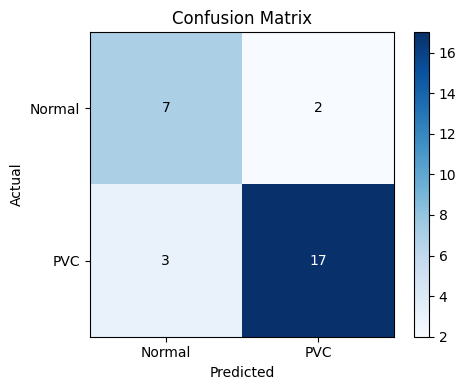

In [ ]:
def prepare_classification_data(normal_features, ventricular_features, feature_names=None, top_n=None):
    """
    X : ndarray, shape (n_samples, n_features)
        Feature matrix
    y : ndarray, shape (n_samples,)
        Labels (0=Normal, 1=Ventricular)
    selected_features : list
        Names of features used
    """
    # get all possible features, and if there are selected feats., we choose them. 
    all_features = list(normal_features.keys())
    if feature_names is not None:
        selected_features = feature_names
    elif top_n is not None: # we choose the top n features. 
        selected_features = all_features[:top_n]
    else:
        selected_features = all_features
    
    # building of the matrices, first the total number of samples (number of rows)
    n_normal = len(normal_features[selected_features[0]])
    n_v = len(ventricular_features[selected_features[0]])
    n_samples = n_normal + n_v
    # and then the number of features (no. of columns) 
    n_features = len(selected_features)
    
    # creation of arrays X and y 
    X = np.zeros((n_samples, n_features))
    y = np.zeros(n_samples)
    
    # we fill the information for all normal and then ventricular beats. 
    for i, feat_name in enumerate(selected_features):
        X[:n_normal, i] = normal_features[feat_name]
    y[:n_normal] = 0
    for i, feat_name in enumerate(selected_features):
        X[n_normal:, i] = ventricular_features[feat_name]
    y[n_normal:] = 1
    
    return X, y, selected_features

def train_knn(X_train, y_train, X_test, k):
    """
    knn : trained classifier
    X_train_scaled, X_test_scaled : scaled data
    scaler : fitted scaler
    """
    # feature normalization for knn (z-score)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # knn training
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train_scaled, y_train)

    return knn, X_train_scaled, X_test_scaled, scaler

def eval_knn(knn, X_test, y_test):
    
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    precision, recall, f1, _= precision_recall_fscore_support(y_test, y_pred, average='binary')
    cm = confusion_matrix(y_test, y_pred)

    # specificity
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    
    print("\nClassification results:")
    print(f"\nAccuracy:     {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision:    {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity:  {specificity:.4f}")
    print(f"F1-Score:     {f1:.4f}")
    
    print("\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Normal  Ventricular")
    print(f"Actual Normal    {tn:3d}      {fp:3d}")
    print(f"       V         {fn:3d}      {tp:3d}")
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }

def find_best_k(X_train, y_train, k_range=range(1, 21)):

    cv_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    best_k = k_range[np.argmax(cv_scores)]
    return best_k

top_n = 5
print(f"\nnumber of features used: {top_n}")

X_tmp, y_tmp, _ = prepare_classification_data(
    normal_features,
    ventricular_features,
    feature_names=feature_names
)

# splitting by patients in groups and features by index 
groups = np.array(normal_sources_samp + ventricular_sources_samp)
gss = GroupShuffleSplit(test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X_tmp, y_tmp, groups))
normal_train_mask = train_idx[train_idx < len(normal_sources_samp)]
ventricular_train_mask = train_idx[train_idx >= len(normal_sources_samp)] - len(normal_sources_samp)

normal_features_train = {
    k: v[normal_train_mask] for k, v in normal_features.items()
}
ventricular_features_train = {
    k: v[ventricular_train_mask] for k, v in ventricular_features.items()
}

# statistical testing on training data only to avoid leakage 
results, significant_features = test_normality_and_compare(
    normal_features_train,
    ventricular_features_train,
    feature_names
)

# selection of top features 
top_features = significant_features[:top_n]

X, y, _ = prepare_classification_data(normal_features, ventricular_features, feature_names=top_features)

X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

# find best k and training. 
best_k = find_best_k(X_train, y_train)
knn, X_train_scaled, X_test_scaled, scaler = train_knn(X_train, y_train, X_test, k=best_k)

# evaluating the model and graphing confusion matrix
metrics = eval_knn(knn, X_test_scaled, y_test)

plt.figure(figsize = (5,4))
plt.imshow(metrics['confusion_matrix'], interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
class_names = ["Normal", "PVC"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

for i in range(metrics['confusion_matrix'].shape[0]): 
    for j in range(metrics['confusion_matrix'].shape[1]): 
        plt.text(j, i, metrics['confusion_matrix'][i,j], ha="center", va="center",
        color = "white" if metrics['confusion_matrix'][i,j] > metrics['confusion_matrix'].max() / 2 else "black")

plt.ylabel("Actual") 
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

In [86]:
# statistical testing on TRAINING data only (prevents leakage)
results, significant_features = test_normality_and_compare(
    normal_features_train,
    ventricular_features_train,
    feature_names
)

max_features_to_test = min(15, len(significant_features))  # Test up to 15 features
n_features_list = []
f1_scores = []
accuracies = []
precisions = []
recalls = []

for n in range(1, max_features_to_test + 1):
    # Select top n features
    top_features_temp = significant_features[:n]
    
    # Build matrices
    X_temp, y_temp, _ = prepare_classification_data(
        normal_features,
        ventricular_features,
        feature_names=top_features_temp
    )
    
    # Split
    X_train_temp = X_temp[train_idx]
    X_test_temp = X_temp[test_idx]
    y_train_temp = y_temp[train_idx]
    y_test_temp = y_temp[test_idx]
    
    # Scale
    scaler_temp = StandardScaler()
    X_train_scaled_temp = scaler_temp.fit_transform(X_train_temp)
    X_test_scaled_temp = scaler_temp.transform(X_test_temp)
    
    # Train with best_k (or use a fixed k like 5 for speed)
    knn_temp = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    knn_temp.fit(X_train_scaled_temp, y_train_temp)
    
    # Evaluate
    y_pred_temp = knn_temp.predict(X_test_scaled_temp)
    acc = accuracy_score(y_test_temp, y_pred_temp)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_temp, y_pred_temp, average='binary'
    )
    
    # Store results
    n_features_list.append(n)
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)

# Find best
best_idx = np.argmax(f1_scores)
best_n_features = n_features_list[best_idx]
best_f1 = f1_scores[best_idx]

print(f"best: {best_n_features} features with F1={best_f1:.4f}")


NORMALITY TESTING AND STATISTICAL COMPARISON

Feature                   Normal p-val    V p-val         Test Used       p-value      Sig?
----------------------------------------------------------------------------------------------------
cA_energy                 0.000288        0.000016        Mann-Whitney    0.000288     yes
cA_mean                   0.269277        0.000823        Mann-Whitney    0.010266     yes
cA_std                    0.440230        0.017626        Mann-Whitney    0.002620     yes
cA_entropy                0.027698        0.095979        Mann-Whitney    0.175061     no
cD5_energy                0.484035        0.002863        Mann-Whitney    0.580315     no
cD5_mean                  0.505022        0.030762        Mann-Whitney    0.140879     no
cD5_std                   0.143018        0.017576        Mann-Whitney    0.596359     no
cD5_max                   0.119369        0.009123        Mann-Whitney    0.930430     no
cD5_entropy               0.000018   


number of features used: 2

NORMALITY TESTING AND STATISTICAL COMPARISON

Feature                   Normal p-val    V p-val         Test Used       p-value      Sig?
----------------------------------------------------------------------------------------------------
cA_energy                 0.000288        0.000016        Mann-Whitney    0.000288     yes
cA_mean                   0.269277        0.000823        Mann-Whitney    0.010266     yes
cA_std                    0.440230        0.017626        Mann-Whitney    0.002620     yes
cA_entropy                0.027698        0.095979        Mann-Whitney    0.175061     no
cD5_energy                0.484035        0.002863        Mann-Whitney    0.580315     no
cD5_mean                  0.505022        0.030762        Mann-Whitney    0.140879     no
cD5_std                   0.143018        0.017576        Mann-Whitney    0.596359     no
cD5_max                   0.119369        0.009123        Mann-Whitney    0.930430     no
cD5_entro

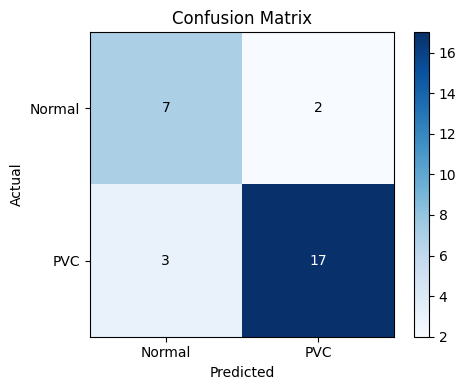

In [88]:
top_n = best_n_features
print(f"\nnumber of features used: {top_n}")

X_tmp, y_tmp, _ = prepare_classification_data(
    normal_features,
    ventricular_features,
    feature_names=feature_names
)

# splitting by patients in groups and features by index 
groups = np.array(normal_sources_samp + ventricular_sources_samp)
gss = GroupShuffleSplit(test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X_tmp, y_tmp, groups))
normal_train_mask = train_idx[train_idx < len(normal_sources_samp)]
ventricular_train_mask = train_idx[train_idx >= len(normal_sources_samp)] - len(normal_sources_samp)

normal_features_train = {
    k: v[normal_train_mask] for k, v in normal_features.items()
}
ventricular_features_train = {
    k: v[ventricular_train_mask] for k, v in ventricular_features.items()
}

# statistical testing on training data only to avoid leakage 
results, significant_features = test_normality_and_compare(
    normal_features_train,
    ventricular_features_train,
    feature_names
)

# selection of top features 
top_features = significant_features[:top_n]

X, y, _ = prepare_classification_data(normal_features, ventricular_features, feature_names=top_features)

X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

# find best k and training. 
best_k = find_best_k(X_train, y_train)
knn, X_train_scaled, X_test_scaled, scaler = train_knn(X_train, y_train, X_test, k=best_k)

# evaluating the model and graphing confusion matrix
metrics = eval_knn(knn, X_test_scaled, y_test)

plt.figure(figsize = (5,4))
plt.imshow(metrics['confusion_matrix'], interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
class_names = ["Normal", "PVC"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

for i in range(metrics['confusion_matrix'].shape[0]): 
    for j in range(metrics['confusion_matrix'].shape[1]): 
        plt.text(j, i, metrics['confusion_matrix'][i,j], ha="center", va="center",
        color = "white" if metrics['confusion_matrix'][i,j] > metrics['confusion_matrix'].max() / 2 else "black")

plt.ylabel("Actual") 
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# 8. Next steps

- fix data leakage issue. 
- write key insights and brief conclusions and findings. 
- work on the introductory part. 
- start working on writing further notes on each stage. 
- revise organization. 
- move onto latex. 